# Imports

In [151]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

sns.set_style('darkgrid')
plt.style.use('ggplot')

## Load Data

In [118]:
path = '/home/edilson07/projects/rp_housing/notebooks/'

df = pd.read_csv(path + 'gtp_analysis.csv')

In [119]:
df.shape

(39860, 13)

In [120]:
df.head()

,nome,preco,quartos,garagem,area,banheiros,condominio,link,tipo,bairro,latitude,longitude,regiao
0,"Vendo apartamento MRV (rio amazonas 1º andar, ...",180000.00,2,1,50,1,205.00,https://sp.olx.com.br/regiao-de-sao-jose-do-ri...,apartamento,Centro,-20.81,-49.38,Centro
1,Apartamento para venda em Jardim Santa Lúcia d...,150000.00,2,1,56,1,220.00,https://sp.olx.com.br/regiao-de-sao-jose-do-ri...,apartamento,Jardim Santa Lúcia,-20.80,-49.40,Cidade das Crianças
2,Apartamento para venda em Centenário Da Emanci...,140000.00,2,1,52,2,0.00,https://sp.olx.com.br/regiao-de-sao-jose-do-ri...,apartamento,Centenário da Emancipação,-20.76,-49.38,CEU
3,Apartamento para venda em Jardim Yolanda de 48...,170000.00,2,1,48,1,240.00,https://sp.olx.com.br/regiao-de-sao-jose-do-ri...,apartamento,Jardim Yolanda,-20.80,-49.35,Represa
4,Apartamento para venda em Eldorado de 60.00m² ...,128000.00,2,1,60,1,0.00,https://sp.olx.com.br/regiao-de-sao-jose-do-ri...,apartamento,Eldorado,-20.79,-49.40,Cidade das Crianças


# Data Description

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39860 entries, 0 to 39859
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   nome        39860 non-null  object 
 1   preco       39860 non-null  float64
 2   quartos     39860 non-null  int64  
 3   garagem     39860 non-null  int64  
 4   area        39860 non-null  int64  
 5   banheiros   39860 non-null  int64  
 6   condominio  39860 non-null  float64
 7   link        39860 non-null  object 
 8   tipo        39860 non-null  object 
 9   bairro      39860 non-null  object 
 10  latitude    39860 non-null  float64
 11  longitude   39860 non-null  float64
 12  regiao      39860 non-null  object 
dtypes: float64(4), int64(4), object(5)
memory usage: 4.0+ MB


In [122]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [123]:
df.describe()

,preco,quartos,garagem,area,banheiros,condominio,latitude,longitude
count,39860.00,39860.00,39860.00,39860.00,39860.00,39860.00,39860.00,39860.00
mean,886400.61,2.82,2.47,201.52,2.86,205.86,-20.81,-49.37
std,990851.11,0.75,1.27,2359.17,1.43,250.49,0.03,0.03
min,15000.00,1.00,1.00,10.00,1.00,0.00,-20.90,-49.46
25%,290000.00,2.00,1.00,80.00,2.00,0.00,-20.83,-49.39
50%,500000.00,3.00,2.00,140.00,3.00,1.80,-20.81,-49.38
75%,1150000.00,3.00,4.00,225.00,4.00,380.00,-20.80,-49.35
max,17000000.00,5.00,5.00,276161.00,5.00,995.00,-20.71,-49.29


## Target Variable(Price)

<Axes: ylabel='preco'>

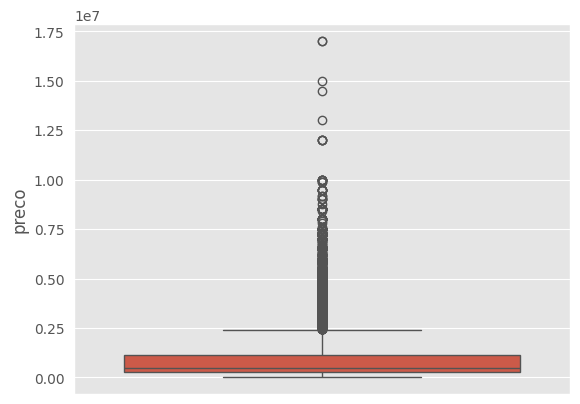

In [124]:
sns.boxplot(df['preco'])

<Axes: xlabel='preco', ylabel='Count'>

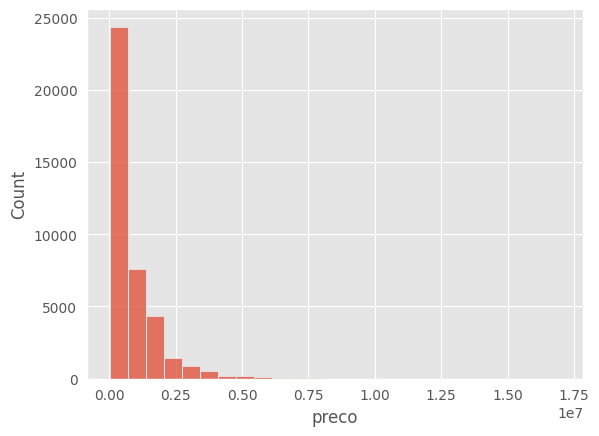

In [125]:
sns.histplot(df['preco'], bins=25)

## Area outlier

<Axes: ylabel='area'>

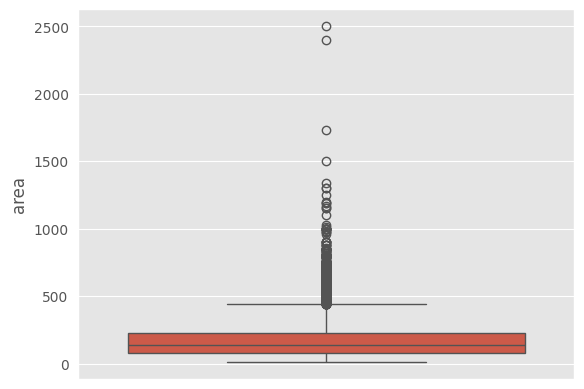

In [154]:
sns.boxplot(df['area'])

In [127]:
df = df.loc[df['area'] < 4000,:]

## Condominio outlier

<Axes: ylabel='condominio'>

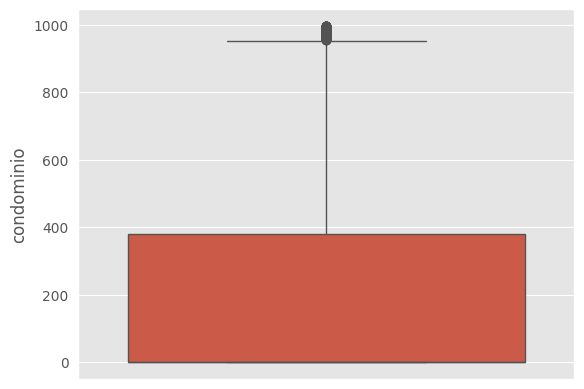

In [128]:
sns.boxplot(df['condominio'])

## Outlier with IQR

In [139]:
# Calculando o IQR para a coluna 'preco'
Q1 = df['preco'].quantile(0.25)
Q3 = df['preco'].quantile(0.75)
IQR = Q3 - Q1

# Definindo os limites inferior e superior
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Filtrando o dataset para remover outliers
data_cleaned = df[(df['preco'] >= lower_limit) & (df['preco'] <= upper_limit)]

# Calculando o IQR para a coluna 'area'
Q1 = df['area'].quantile(0.25)
Q3 = df['area'].quantile(0.75)
IQR = Q3 - Q1

# Definindo os limites para outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrando os dados para remover outliers
data_cleaned = data_cleaned[(data_cleaned['area'] >= lower_bound) & (data_cleaned['area'] <= upper_bound)]

In [140]:
data_cleaned.shape

(36609, 13)

# Preprocess

In [141]:
# Definindo as colunas que serão escalonadas
cols_to_scale = ['quartos', 'garagem', 'area', 'banheiros', 'condominio', 'latitude', 'longitude']

# Inicializando o escalonador
scaler = StandardScaler()

# Escalonando as colunas
data_cleaned[cols_to_scale] = scaler.fit_transform(data_cleaned[cols_to_scale])

# Verificando as primeiras linhas do dataset após o escalonamento
data_cleaned[cols_to_scale].head()

# Codificando a variável 'regiao' usando one-hot encoding
data_cleaned = pd.get_dummies(data_cleaned, columns=['regiao'])

# Criando uma codificação de frequência para a coluna 'bairro'
bairro_freq = data_cleaned['bairro'].value_counts(normalize=True)
data_cleaned['bairro'] = data_cleaned['bairro'].map(bairro_freq)

data_cleaned['tipo'] = data_cleaned['tipo'].apply(lambda x: 1 if  x == 'casa' else 0)

In [142]:
data_cleaned.head()

,nome,preco,quartos,garagem,area,banheiros,condominio,link,tipo,bairro,...,regiao_BOSQUE,regiao_CEU,regiao_Centro,regiao_Cidade das Crianças,regiao_HB,regiao_Pinheirinho,regiao_Represa,regiao_Schimidt,regiao_Talhados,regiao_Vila Toninho
0,"Vendo apartamento MRV (rio amazonas 1º andar, ...",180000.00,-1.06,-1.10,-1.15,-1.25,0.03,https://sp.olx.com.br/regiao-de-sao-jose-do-ri...,0,0.05,...,False,False,True,False,False,False,False,False,False,False
1,Apartamento para venda em Jardim Santa Lúcia d...,150000.00,-1.06,-1.10,-1.08,-1.25,0.09,https://sp.olx.com.br/regiao-de-sao-jose-do-ri...,0,0.00,...,False,False,False,True,False,False,False,False,False,False
2,Apartamento para venda em Centenário Da Emanci...,140000.00,-1.06,-1.10,-1.13,-0.51,-0.84,https://sp.olx.com.br/regiao-de-sao-jose-do-ri...,0,0.00,...,False,True,False,False,False,False,False,False,False,False
3,Apartamento para venda em Jardim Yolanda de 48...,170000.00,-1.06,-1.10,-1.17,-1.25,0.18,https://sp.olx.com.br/regiao-de-sao-jose-do-ri...,0,0.02,...,False,False,False,False,False,False,True,False,False,False
4,Apartamento para venda em Eldorado de 60.00m² ...,128000.00,-1.06,-1.10,-1.03,-1.25,-0.84,https://sp.olx.com.br/regiao-de-sao-jose-do-ri...,0,0.01,...,False,False,False,True,False,False,False,False,False,False


# Machine Learning

In [143]:
X = data_cleaned.drop(['nome','preco','link'], axis=1)
y = data_cleaned['preco']

In [144]:
X.head()

,quartos,garagem,area,banheiros,condominio,tipo,bairro,latitude,longitude,regiao_BOSQUE,regiao_CEU,regiao_Centro,regiao_Cidade das Crianças,regiao_HB,regiao_Pinheirinho,regiao_Represa,regiao_Schimidt,regiao_Talhados,regiao_Vila Toninho
0,-1.06,-1.10,-1.15,-1.25,0.03,0,0.05,-0.03,-0.22,False,False,True,False,False,False,False,False,False,False
1,-1.06,-1.10,-1.08,-1.25,0.09,0,0.00,0.46,-1.04,False,False,False,True,False,False,False,False,False,False
2,-1.06,-1.10,-1.13,-0.51,-0.84,0,0.00,1.84,-0.25,False,True,False,False,False,False,False,False,False,False
3,-1.06,-1.10,-1.17,-1.25,0.18,0,0.02,0.28,0.87,False,False,False,False,False,False,True,False,False,False
4,-1.06,-1.10,-1.03,-1.25,-0.84,0,0.01,0.79,-1.03,False,False,False,True,False,False,False,False,False,False


In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [146]:
X_train.shape, X_test.shape

((29287, 19), (7322, 19))

In [148]:
from sklearn.ensemble import RandomForestRegressor

# Inicializando o modelo de Floresta Aleatória
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

random_forest_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [152]:
y_pred_rf = random_forest_model.predict(X_test)

# Calculando métricas de avaliação
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

mse_rf, rmse_rf, mae_rf, r2_rf

(20204190785.722946, 142141.44640365435, 80326.46807646181, 0.9267295014723876)

In [156]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Definindo os hiperparâmetros e o espaço de pesquisa
param_dist = {
    'n_estimators': np.arange(50, 301, 50),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': np.arange(10, 101, 10),
    'min_samples_split': np.arange(2, 11, 2),
    'min_samples_leaf': np.arange(1, 11, 2)
}

# Inicializando o RandomizedSearchCV
random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Executando a pesquisa aleatória
random_search.fit(X_train, y_train)

# Melhores hiperparâmetros encontrados
best_params = random_search.best_params_
best_params

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/edilson07/.pyenv/versions/3.10.11/envs/rp_houses/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
9 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/home/edilson07/.pyenv/versions/3.10.11/envs/rp_houses/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/edilson07/.pyenv/versions/3.10.11/envs/rp_houses/lib/python3.10/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/home/edilson07/.pyenv/versions/3.10.11/envs/rp_houses/li

{'n_estimators': 250,
 'min_samples_split': 8,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 90}

In [157]:
y_pred_rf = random_search.predict(X_test)

# Calculando métricas de avaliação
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

mse_rf, rmse_rf, mae_rf, r2_rf

(19467511234.580235, 139526.02350307355, 85069.87611891037, 0.9294010698880584)